In [1]:
# Cite: https://www.kaggle.com/code/saurav9786/recommender-system-using-amazon-reviews#Collaberative-filtering-(Item-Item-recommedation)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
import nltk
import sys
from sklearn.decomposition import TruncatedSVD
%matplotlib inline

In [2]:
data_path = "./data/Digital_Music_5.json"
table = pd.read_json(data_path, 'records', lines = True).reset_index(drop = True, inplace = False)

In [3]:
from collections import defaultdict
from textblob import TextBlob
def get_sentiment(table):
    polarity = []
    subjectivity = []
    for idx, row in table.iterrows():
        review = TextBlob(row['reviewText'])
        sentiment = review.sentiment
        polarity.append(sentiment.polarity)
        subjectivity.append(sentiment.subjectivity)
    new_table = table
    new_table.insert(len(table.columns), column='polarity', value=polarity)
    new_table.insert(len(table.columns), column='subjectivity', value=subjectivity)
    return new_table

In [4]:
table = get_sentiment(table)

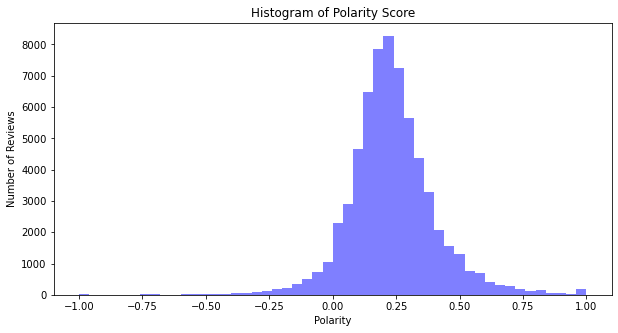

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
num_bins = 50
plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(table.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

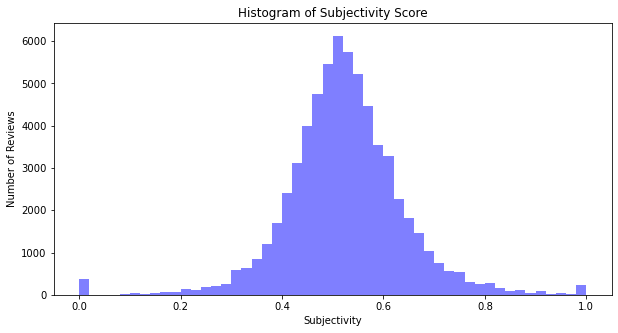

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
num_bins = 50
plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(table.subjectivity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Subjectivity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Subjectivity Score')
plt.show();

In [7]:
#deal with the bias and noise of the overall column
def unbias(overall, polarity, subjectivity):
    if subjectivity > 0.5:
        return ((overall+5*polarity*(2-subjectivity*2))+4)*4/14+1
    else:
        return ((overall+5*polarity*subjectivity*2)+4)*4/14+1
table['unbias_overall'] = table.apply(lambda row: unbias(row['overall'], row['polarity'], row['subjectivity']), axis=1)
display(table.head())

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,polarity,subjectivity,unbias_overall
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5,Enya's last great album,1158019200,"09 12, 2006",0.186515,0.501742,3.836950
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5,Enya at her most elegant,991526400,"06 3, 2001",0.251479,0.507298,3.925441
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5,The best so far,1058140800,"07 14, 2003",0.343074,0.668615,3.896256
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5,Ireland produces good music.,957312000,"05 3, 2000",0.463788,0.459293,4.180041
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4,4.5; music to dream to,1200528000,"01 17, 2008",0.342808,0.580449,3.696643


In [8]:
table.shape

(64706, 12)

In [9]:
table.describe()['unbias_overall'].T

count    64706.000000
mean         3.620390
std          0.411975
min          1.285714
25%          3.454510
50%          3.719636
75%          3.893764
max          5.000000
Name: unbias_overall, dtype: float64

In [10]:
print('Number of missing values across columns: \n',table.isnull().sum())

Number of missing values across columns: 
 reviewerID          0
asin                0
reviewerName      177
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
polarity            0
subjectivity        0
unbias_overall      0
dtype: int64


In [11]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",table.shape[0])
print("Total No of Users   :", len(np.unique(table.reviewerID)))
print("Total No of products  :", len(np.unique(table.asin)))

Total data 
--------------------------------------------------

Total no of ratings : 64706
Total No of Users   : 5541
Total No of products  : 3568


In [12]:
table.drop(['reviewerName'], axis=1,inplace=True)
table.drop(['helpful'], axis=1,inplace=True)
table.drop(['reviewText'], axis=1,inplace=True)
table.drop(['summary'], axis=1,inplace=True)
table.drop(['unixReviewTime'], axis=1,inplace=True)
table.drop(['reviewTime'], axis=1,inplace=True)
table.drop(['polarity'], axis=1,inplace=True)
table.drop(['overall'], axis=1,inplace=True)
table.drop(['subjectivity'], axis=1,inplace=True)

In [13]:
no_of_rated_products_per_user = table.groupby(by='reviewerID')['unbias_overall'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

reviewerID
A9Q28YTLYREO7     578
A3HU0B9XUEVHIM    375
A3KJ6JAZPH382D    301
A3C6ZCBUNXUT7V    261
A8IFUOL8S9BZC     256
Name: unbias_overall, dtype: int64

In [14]:
no_of_rated_products_per_user.describe()

count    5541.000000
mean       11.677676
std        18.222800
min         5.000000
25%         5.000000
50%         7.000000
75%        11.000000
max       578.000000
Name: unbias_overall, dtype: float64

In [15]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 126



In [16]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split,cross_validate

In [17]:
#Reading the dataset
new_df=table.groupby("asin").filter(lambda x:x['unbias_overall'].count() >=50)
reader = Reader(rating_scale=(1, 5))
cols = new_df.columns.tolist()
df = new_df[cols] 
data = Dataset.load_from_df(df,reader)

In [18]:
results = cross_validate(SVD(), data, measures=['RMSE'], cv=10, verbose=False)
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
print(tmp)

test_rmse    0.385831
fit_time     0.112400
test_time    0.007900
dtype: float64


In [19]:
trainset, testset = train_test_split(data, test_size=0.2)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
predictions[:5]
accuracy.rmse(predictions)

[Prediction(uid='A2TAPL67U2A5HM', iid='B000OQF6N6', r_ui=3.2196481481481483, est=3.3976803879509356, details={'was_impossible': False}),
 Prediction(uid='AUCJ0EMRPHV3C', iid='B00014TQ7S', r_ui=3.7936130952380958, est=3.5611642443191043, details={'was_impossible': False}),
 Prediction(uid='A3TXWIDMKRYG3J', iid='B000KCHZK6', r_ui=3.7192460317460316, est=3.4234357399636144, details={'was_impossible': False}),
 Prediction(uid='A2BEU7GPGNIG44', iid='B000AA303Y', r_ui=3.811395746579417, est=3.659620514110046, details={'was_impossible': False}),
 Prediction(uid='A11NKZ57YSELZC', iid='B0000029DD', r_ui=3.808366962629172, est=3.7571620477866534, details={'was_impossible': False})]

RMSE: 0.3818


0.3818328871463287

In [20]:
ratings_matrix = new_df.pivot_table(values='unbias_overall',
        index='reviewerID', columns='asin', fill_value=0)
X = ratings_matrix.T
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
correlation_matrix = np.corrcoef(decomposed_matrix)

In [21]:
X.index[253]

'B005QJZ5FA'

In [22]:
i = "B005QJZ5FA"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

253

In [23]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(254,)

In [24]:
Recommend = list(X.index[correlation_product_ID > 0.65])

Recommend.remove(i) 

Recommend[0:10]

['B000000TDH',
 'B000001DZO',
 'B0000025WQ',
 'B000002J2S',
 'B000002VN7',
 'B000002VT6',
 'B00000DGUG',
 'B00000IAU3',
 'B00001QGQI',
 'B00004Z41Q']